# Dual CRISPR Screen Analysis
# Step 8: Construct Scoring

Roman Sasik, CCBB, UCSD (rsasik@ucsd.edu)

Amanda Birmingham, CCBB, UCSD (abirmingham@ucsd.edu)

## Instructions

To run this notebook reproducibly, follow these steps:
1. Click **Kernel** > **Restart & Clear Output**
2. When prompted, click the red **Restart & clear all outputs** button
3. Fill in the values for your analysis for each of the variables in the [Input Parameters](#Input-Parameters) section
4. Click **Cell** > **Run All**

**Note**: All file outputs will be stored into the directory in which this notebook resides.

## Input Parameters

In [1]:
# IMPORTANT!  IMPORTANT! IMPORTANT!
# ---------------------------------
# Change below value to False if running on real data! Should be set to *True* ONLY when testing!
g_use_seed = True # TODO: This should be *False* when running on real data!
# Change below value to 1000 if running on real data! Should be set to *2* ONLY when testing!
g_num_iterations = 2 # TODO: This should be *1000* when running on real data!
# ---------------------------------

# Required format for counts file:  Count file must be a tab-delimited 
# text file containing one row for each construct in library.  File must have
# a header line (although count column names will be ignored) and must contain
# the following columns in this order; 2-5 must have the specified names:
# 1: construct id (NB: this column is expected but not currently used)
# 2: probe_a_id
# 3: probe_b_id
# 4: target_a_id
# 5: target_b_id
# subsequent: one column for counts of the construct in question at each 
# timepoint-by-replicate combination (e.g., day 3 replicate 1).  These must 
# be ordered by timepoint and then by replicate (e.g., day 3 replicate 1, 
# day 3 replicate 2, day 14 replicate 1, day 14 replicate 2, etc).
# The number of timepoints represented must match the number given in the
# g_day_timepoints_str variable below.  The number of replicates is assumed
# to be two.
# Note that there MUST NOT be data for more than one screen in the same file,
# as code doesn't check screen identity of columns bc assumes are from same screen (e.g., say, A549_CV4)
g_counts_fp = ('/Users/Birmingham/Work/Repositories/ccbb_tickets_2017/mali-dual-crispr-pipeline/src/python/'
    'test_files/known_goods/A549_CV4_counts_w_everything_pseudo_timepoint_counts.txt')
g_day_timepoints_str = "3,14,20,28"
g_dataset_name = "A549_CV4_3-14-21-28_NA_combined_simple-null-w-lfdr"
g_thresholds_run_prefix = "A549_CV4_counts_w_everything"
g_thresholds_dir = ('/Users/Birmingham/Work/Repositories/ccbb_tickets_2017/mali-dual-crispr-pipeline/src/python/'
    'test_files/known_goods')
g_scoring_dir = ('/Users/Birmingham/Work/Repositories/ccbb_tickets_2017/mali-dual-crispr-pipeline/src/python/'
    'test_files/test_outputs/notebook8_A549_CV4_counts_w_everything')

g_code_location = '/Users/Birmingham/Work/Repositories/ccbb_tickets_2017/mali-dual-crispr-pipeline/src/python/'
g_cran_repo ='http://cran.us.r-project.org'
# Note: a list of CRAN mirror sites is at https://cran.r-project.org/mirrors.html

In [2]:
import inspect
import sys
sys.path.append(g_code_location)

import ccbbucsd.utilities.analysis_run_prefixes as ns_runs
import ccbbucsd.utilities.files_and_paths as ns_files
import ccbbucsd.utilities.notebook_logging as ns_logs


def describe_var_list(input_var_name_list):
    description_list =  ["{0}: {1}\n".format(name, eval(name)) for name in input_var_name_list]
    return "".join(description_list)


ns_logs.set_stdout_info_logger()

In [23]:
ns_files.verify_or_make_dir(g_scoring_dir)

## Abundance Thresholds Import

In [3]:
import ccbbucsd.malicrispr.scoring_prep as ns_prep
print(inspect.getsource(ns_prep.get_abundance_thresh_file_suffix))
print(inspect.getsource(ns_prep.get_sample_name_header))

def get_abundance_thresh_file_suffix():
    return "abundance_thresholds.txt"

def get_sample_name_header():
    return "sampleName"



In [4]:
import pandas

def get_abundance_thresholds_df(thresholds_dir, thresholds_run_prefix):
    thresholds_suffix = ns_prep.get_abundance_thresh_file_suffix()
    thresholds_fp = ns_files.build_multipart_fp(thresholds_dir, [thresholds_run_prefix, thresholds_suffix])       
    result = pandas.read_table(thresholds_fp, index_col=ns_prep.get_sample_name_header())    
    return result

In [5]:
g_abundance_threshs_df = get_abundance_thresholds_df(g_thresholds_dir, g_thresholds_run_prefix)
g_abundance_threshs_df

,log2CountsThresh
sampleName,
A549CV4_T3_1,3.339758
A549CV4_T3_2,3.325000
A549CV4_T14_1,3.922481
A549CV4_T14_2,4.247924
A549CV4_T21_1,4.525000
A549CV4_T21_2,4.325000
A549CV4_T28_1,4.725000
A549CV4_T28_2,4.525000


## R Magic Import

In [6]:
%load_ext rpy2.ipython

## Variable Transfer from Python to R

In [7]:
from rpy2.robjects import r
import rpy2.robjects as robjects

gR = robjects.r
# 'temp' assignments suppress printing of cruft stdout
temp = gR.assign('input_filename', g_counts_fp)
temp = gR.assign('g_time_str', g_day_timepoints_str)
temp = gR.assign('project', g_dataset_name)
temp = gR.assign('gUseSeed', g_use_seed)
temp = gR.assign('niter', g_num_iterations)
temp = gR.assign('gAbundanceThreshsDf', g_abundance_threshs_df)
temp = gR.assign('gScoringDir', g_scoring_dir)
temp = gR.assign('g_cran_repo_url', g_cran_repo)

In [8]:
%%R
 
commaSepStringToNumVector<-function(commaSepString){
    strVector = unlist(strsplit(commaSepString, ",", fixed=TRUE))
    return(as.numeric(strVector))
}

time = commaSepStringToNumVector(g_time_str)

## R Library Installation

In [9]:
import warnings
with warnings.catch_warnings():
    # NB: rpy2 spits a lot of status messages about installation
    # as "warnings".  The below filter line can be commented out 
    # if you aren't scared of seeing them :)
    warnings.simplefilter("ignore")
    
    %R install.packages("MASS", repos=g_cran_repo_url)
    %R library(MASS)
    
    %R install.packages("locfdr", repos=g_cran_repo_url)
    %R library(locfdr)
    
    %R source("http://bioconductor.org/biocLite.R")
    %R biocLite("qvalue", suppressUpdates=TRUE)
    %R library(qvalue)

## Shared R Functions

In [10]:
%%R

Var<-function(x) mean(x^2)-mean(x)^2 #scalar version
vVar<-function(x) apply(x^2,1,mean)-apply(x,1,mean)^2 #vector version

Cov<-function(x,y) mean(x*y)-mean(x)*mean(y)
vCov<-function(x,y) apply(t(x)*y,2,mean)-apply(x,1,mean)*mean(y) #x is a matrix and y is a vector

sqrtsum<-function(y) sqrt(sum(y^2))
    

# x1 is log2 frequencies for the 1st replicate of all timepts
# x2 is log2 frequencies for the 2nd replicate of all timepts
# ab1 is abundance thresholds for all 1st replicates
# ab2 is abundance thresholds for all 2nd replicates
fit_ac_fc<-function(x1,ab1,x2,ab2) { #badx is TRUE when x-value is bad

   er_ac<-1
   l<-0
   nx<-nrow(x1)
    
# Prediction: useless1 and useless2 here should have the same values as bad1 and bad2 in the 
# Number of Constructs Below Abundance Threshold section ... boxed code seems to calc same result
# as code in that section, but by slightly diff (but equivalent) means
# -------------------
# t(x1) has timept as rows and constructs as columns.  
# I can't for the life of me figure out why it is necessary to transpose x1, compare it to ab1, 
# and then transpose it back ... since the ">ab1" evaluation will be at the individual cell level,
# and the individual cells hold log2 frequency values no matter which way you set up the rows and cols,
# and since no margin calculations are being done in the good1 calculation, .... WHY?
   good1<-t(t(x1)>ab1) # constructs as rows, timept for 1st replicates ONLY as cols, cell values are 0/FALSE, 1/TRUE for whether log2 freq for row/col combination is above relevant abundance threshold
   good2<-t(t(x2)>ab2) # constructs as rows, timept for 2nd replicates ONLY as cols, cell values are 0/FALSE, 1/TRUE for whether log2 freq for row/col combination is above relevant abundance threshold
   useless1<-apply(good1,1,sum)<2 # 1 = sum over rows--i.e., constructs.  Any construct that isn't above abundance threshold in 1st replicate in at least 2 timepoints has 1/TRUE in "useless" matrix
   useless2<-apply(good2,1,sum)<2
    
    # ab
    print(sum(useless1))
    print(sum(useless2))
    # PREDICTION CORRECT!
# --------------------
    
# I do not understand how the statements below actually *remove* anything from the good1 and good2 dfs ...
# It seems like, for each constructs that isn't above abundance thresholds in at least two timepoints for this replicate, it sets that construct's "good" values to FALSE for *all* timepoints in this replicate
   good1[useless1,]<-FALSE #remove singletons
   good2[useless2,]<-FALSE #remove singletons
   
    # Note: here apply(goodX,1,sum) is NOT uselessX because goodX was changed above
    #allbad is true for all the constructs that lack at least 2 acceptable-abundance timepoints in BOTH experiments
   allbad<-apply(good1,1,sum)<2 & apply(good2,1,sum)<2 #in this case I have nothing to use in either experiment

    # nt = number of timepoints
   lambda1<-rep(0,nt)
   lambda2<-rep(0,nt)
   ac1<-x1[,1] #just a guess # log2 frequencies for all constructs for first timepoint in this replicate
   ac2<-x2[,1] #just a guess
   fc<-rep(0,nx) # nx = number of constructs

    # for 1 to number of constructs
   for (i in 1:nx) {
       # if this construct doesn't have at least two timepoints above abundance threshold in at least one replicate, ignore it and move on
      if (allbad[i]) next #from now on there is at least one good experiment
          
    # apparently "f" stands for fitness--which is covariance (see below)--and # stands for replicate
    # v stands for variance and # " "
      f1<-0
      f2<-0
      v1<-0
      v2<-0
          
      g1<-good1[i,] # g1 = true/false values of whether construct i passes various abundance filters for all timepoints for the first replicate 
      if (sum(g1)>1) { #it's a good experiment # if there are at least two good timepoints for this construct in replicate 1
         mx1<-mean(x1[i,g1]) # get the mean of the log2 frequencies for all the good timepoints for this construct in replicate 1
          # time is GLOBAL vector of timepoints (numbers, usually in days, in ascending order)
         mt1<-mean(time[g1]) # get mean of timepoints (e.g. mean number of days) for all the good timepoints for this construct in replicate 1
         v1<-Var(time[g1]) # get variance of timepoints " "
         f1<-Cov(x1[i,g1],time[g1]) # f1 = covariance of log2 frequencies for all the good timepoints for this construct in replicate 1 with the timepoints for those good timepoints
      }
          
      # do the exact same thing as above, but for replicate 2
      g2<-good2[i,]
      if (sum(g2)>1) { #it's a good experiment
         mx2<-mean(x2[i,g2])
         mt2<-mean(time[g2])
         v2<-Var(time[g2])
         f2<-Cov(x2[i,g2],time[g2])
      }
      
    # fc[i] is the combined fitness (across replicates) for construct i
      fc[i]<-(f1+f2)/(v1+v2) #the combined fitness from replicate 1+2
      #fc remains defined up to an additive constant

      if (sum(g1)>1) { # if there are at least two good timepoints for this construct in replicate 1
          # ac1 = mean of log2 freqs for this construct for good timepoints for rep 1 - (mean of timepts for good timepoints for this construct for rep 1)*combined fitness across replicates for this construct
         ac1[i]<-mx1-fc[i]*mt1
      }
    
    # same as above but for replicate 2
      if (sum(g2)>1) {
         ac2[i]<-mx2-fc[i]*mt2
      }
   }
    
    # ac is the initial condition (in log2 frequency) for construct c 
    # this is normalizing ac1 ... I think this is what is going on:
    # Roman's methods say "By definition, log2 relative frequencies satisfy the constraint
    # sum over c of (2^xc) = 1 at all times"
    # ac1 is the set of log2 frequencies for all constructs in replicate 1 at "initial conditions", so 
    # ac1 must satisfy the above constraint.  IFF the above constraint is satisfied, -log2(1) = 0.
    # If the above constraint isn't satisfied, the value of -log2(sum over c of (2^ac)) is subtracted from
    # ac to ensure the constraint is satisfied.
   alpha<- -log2(sum(2^ac1)) 
   ac1<-ac1+alpha #enforce normalization at time=0, sum(2^ac)=1
       
    # same as above but for replicate 2
   alpha<- -log2(sum(2^ac2))
   ac2<-ac2+alpha #enforce normalization at time=0, sum(2^ac)=1

    # ok, the *expected* log2 frequency for construct x at time t is:
    # xc(t) = ac + fc*t - log2(sum over c of 2^(ac + fc*t))
    # apparently the below code calls the term starting with "-log2" "lambda".
    # Note that lambda is being calculated separately for each combination of timepoint+replicate
       
    # for 1 to number of timepoints
   for (i in 1:nt) {
      lambda1[i]<- -log2(sum(2^(ac1+fc*time[i])))
      lambda2[i]<- -log2(sum(2^(ac2+fc*time[i])))
   } #these are initial estimates of lambda(t)

    # x1 is log2 frequencies for the 1st replicate of all timepts
   xfit1<-x1 #for size # I think this means that xfitX is being set to xX not because we're using *any* of the
    # xX values but just to initialize xfitX to the desired size (which is the same as the size of xX)
    
    # for 1 to number of timepoints
   for (j in 1:nt) {
       # the expected value of xc(t) at this timepoint t, calculated as a column for all constructs c
      xfit1[,j]<-ac1+fc*time[j]+lambda1[j]
   }
       
    # same as above but for replicate 2
   xfit2<-x2 #for size
   for (j in 1:nt) {
      xfit2[,j]<-ac2+fc*time[j]+lambda2[j]
   }

       
   sdfc<-rep(0.1,nx) #standard error of fc
   tstat<-rep(0,nx) # presumably t statistic
   df<-rep(0,nx) # df = vector w one entry for each construct, with value from 0 to -2; 0 if both replicates of relevant construct are good, -1 if just one is, -2 if neither are.  Inits to 0 for all
   p_t<-rep(1,nx) # p value from t test ... initialize to 1 (not significant) for everything
       
    # for 1 to number of constructs
   for (i in 1:nx) {
       # if this construct doesn't have enough "good" measurements, skip it
      if (allbad[i]) next
      
        
      g1<-good1[i,] # g1 = true/false values of whether construct i passes various abundance filters for all timepoints for the first replicate 
      g2<-good2[i,]
    
        # df = vector w one entry for each construct, with value from 0 to -2; 0 if both replicates of relevant construct are good, -1 if just one is, -2 if neither are
        # I suspect that "df" is "degrees of freedom" for each construct
      df[i]<-sum(g1)+sum(g2)-2
          
        # sqrtsum<-function(y) sqrt(sum(y^2))
        # outside of this function, this sdfc value is used only in the output of the construct file
        # I think that sdfc is "standard deviation of fc" for each construct.
          
        # So: while I don't claim to understand why, I know that Roman says:
        # std err of fc = sqrt of sum over t of (lower-case-epsilon for construct c, as a function of t)^2
        # divided by sqrt of (nc - 2)*sum over t of (t^2 - (mean of t)^2)
        # Note that lower-case-epsilon is Xc(t) - xc(t) = xX - xfitX
        # so xfitX - xX = - lower-case-epsilon ... but since it is being squared and then square-rooted, I
        # suppose the negation doesn't matter.
        # nc - 2 is the number of degrees of freedom
        # where nc = number of data points = 2*nt minus any number of points below the threshold
        # (note the description above seems to assume 2 replicates) ... seems to me this must mean 
        # number of data points *for this construct c*, not total.
        # nt in above is number of timepoints, as here ...
        # Roman also says that tc [i.e., the t statistic for construct c] = fc /SE(fc)
        # and the internet tells me that SE(x) = SD(x)/sqrt(n) ... but maybe the sqrt(n) is just the most usual
        # sqrt of degrees of freedom, and could be something else in a more complex system.
        # So, the value being calculated directly below is SD(x), which is why it doesn't have the
        # nc - 2 term that is in the denominator of the SE(x) calculation (in the manuscript, Roman says that
        # fc's sd = sqrt(nc-2)*SE(fc), where nc-2 = degrees of freedom.  Farther below, after the calculation
        # of sdfc, we get the calculation of tc, which is fc/(sdfc/sqrt(df)), where the sdfc/sqrt(df) term 
        # is the calculation of SE(fc).
          
    # result is vector with one std dev of fc for each construct
      sdfc[i]<-sqrtsum( c(xfit1[i,g1],xfit2[i,g2]) - c(x1[i,g1],x2[i,g2]) ) /
          sqrtsum( c(time[g1],time[g2]) - mean(c(time[g1],time[g2])) )
          
   }
   #find median sd
   has_sd<-df>0
   median_sd<-median(sdfc[has_sd])
   sdfc[!has_sd]<-median_sd #just so it isn't 0
   
   # for 1 to number of constructs
   for (i in 1:nx) {
       # don't try to calculate t statistic and p value for any fc that doesn't have a stderr
      if (!has_sd[i]) next
        # calc t statistic of fc
      tstat[i]<-fc[i]/(sdfc[i]/sqrt(df[i]))
        # pt is R function, presumably to do t-test :)  Result must be one-tailed, hence *2
      p_t[i]<-2*pt(-abs(tstat[i]),df=df[i]) #raw p-values from t-test
   }
       
    # ok, lfdr stands for "local fdr", and the lfdr function comes from the qvalue bioconductor package
    # that is installed way above.  The first input is the vector of p-values, and the second input is the
    # estimated proportion of true null p-values, where pi0.method is "the method for automatically choosing tuning
    # parameter in the estimation of π0, the proportion of true null hypotheses."
   lfdr_fc<-rep(1,nx) # nx = number of constructs; default value of lfdr is set to one for all of them
   l<-lfdr(p_t[has_sd],pi0.method="bootstrap")
   lfdr_fc[has_sd]<-l # for constructs that have an sd, the lfdr of the fc could be calculated and is now set
       # to its calculated vale instead of the default

    # ac1 is the initial condition (in log2 frequency) for each construct c for replicate 1
    # ac2 is the initial condition (in log2 frequency) for each construct c for replicate 2
    # fc is the fitness of each construct c (calculated across both replicates)
    # sdfc is the std deviation of the fitness of each construct c (calculated across both replicates)
    # p_t is the raw p value of the fc of each construct c (calculated across both replicates)
    # lfdr_fc is the local FDR of each construct (calculated across both replicates)
    # df is the degrees of freedom of each construct c (calculated across both replicates)
    # allbad is a boolean value for each construct c that is true for all the constructs that lack at least 2 acceptable-abundance timepoints in BOTH experiments
   vl<-list(ac1,ac2,fc,sdfc,p_t,lfdr_fc,df,allbad)
   return(vl)
}

plot_fit<-function(x1,ac1,fc1,ab1,x2,ac2,fc2,ab2,minfc=0.10) {

   nx<-nrow(x1)
   maxt<-time[nt]+3
   plot_lambda1<-rep(0,maxt)
   plot_lambda2<-rep(0,maxt)

    # TODO: Do these 1, 2 represent hardcoding of # of expected replicates?  If so, need to refactor function
   good1<-t(t(x1)>ab1)
   good2<-t(t(x2)>ab2)
   allbad<-apply(good1,1,sum)<2 & apply(good2,1,sum)<2 #in this case I have nothing to use in either experiment

   for (i in 1:maxt) plot_lambda1[i]<- -log2(sum(2^(ac1+fc1*i)))
   for (i in 1:maxt) plot_lambda2[i]<- -log2(sum(2^(ac2+fc2*i)))
   
   rge<-range(c(x1,x2))
   for (i in 1:nx) {
      if (allbad[i]) next
      if (abs(fc1[i])<minfc & abs(fc2[i])<minfc) next
      pch<-rep(1,nt)
      pch[good1[i,]]<-16 #circle
      plot(time,x1[i,],ylim=rge,pch=pch,cex=1.2,main=pA_pB[i],xlab="time",ylab=expression(paste(log[2]," relative frequency")))
      yfit<-ac1[i]+fc1[i]*(1:maxt)+plot_lambda1
      lines(1:maxt,yfit)

      pch<-rep(1,nt)
      pch[good2[i,]]<-16 
      points(time,x2[i,],pch=pch,cex=1.2,col="blue")
      yfit<-ac2[i]+fc2[i]*(1:maxt)+plot_lambda2
      lines(1:maxt,yfit,col="blue")
   }
}

#iterative robust least squares
# fc is a symmetric probe-by-probe matrix where the value in each cell is the fc value for the construct including
# those two probes, or zero if there is no construct for that probe-by-probe combination.
# w0 is a symmetric probe-by-probe matrix of initial weights, where the value in each cell is zero for "bad"
# and/or non-existent constructs and one for "good" constructs.
# The manuscript gives eqn 2 as:
# fc = fp + fp' + pi sub pp'
# and states "The probe fitnesses are found by robust fitting of Eq. (2). 
# The probe-level pi-scores are the residuals of the robust fit."
irls<-function(fc,w0,probes,ag=2,tol=1e-3,maxiter=30) {
# w0 is the physical goodness of constructs. It is not subject to change. # ab: what is "physical goodness"??
# It is used to modify w, to silence bad constructs 

    # upper.tri seems to be getting the upper triangle of the symmetric probe-by-probe fc matrix
    # What data structure is expressed_utri? a matrix of fc values?  or a matrix of booleans? or ...?
   expressed_utri<-upper.tri(fc) & w0>0
   n<-dim(fc)[1] # lessee--that would be number of probes; note that n here is *different* than n outside the scope of this function, where it is the number of genes :(
   w<-matrix(1,nrow=n,ncol=n) #initial weights # ab: probe-by-probe matrix with default values of 1 everywhere except on diagonal, where they are zero
   diag(w)<-0
    # errr.  what are e and f?
   fij<-matrix(0,nrow=n,ncol=n) #initial weights
   eij<-matrix(0,nrow=n,ncol=n) #initial weights
   b<-rep(0,n) #rhs #ab: wth is rhs?

   #iteration step 0
   w<-w*w0 # I think here we are "silenc[ing] bad constructs", which have w0 = 0
   A<-w
   for (i in 1:n) { # for each probe
      b[i]<-sum(fc[,i]*w[,i]) # sum of fc*weight for all probes paired with this probe.  Why set i as the second index into in the probe-by-probe matrix rather than the first?  Isn't the matrix symmetric?
      A[i,i]<-sum(w[,i])+small # reminder: small<-1e-6 ; it is a parameter hardcoded at the top of the whole notebook.
        # so, A = w and w is 1 everywhere except on the diagonal and at probe-by-probe pairs where the analogous 
        # construct is either bad or non-existent.  This seems to be setting the values along the diagonal to the
        # sum of the weights for that probe (across all other probes it is paired with) plus a tiny value, presumably
        # to make sure the diagonal is now *never* zero.
   }
    
    # apparently, "solve() function solves equation a %*% x = b for x, where b is a vector or matrix." (from http://www.endmemo.com/program/R/solve.php)
    # Note that %*% is apparently R notation for "multiply matrices".  Ok, so figure out what matrix you need to multiply A by to get b,
    # and call that matrix y (again, note y here is *different* from y outside this function, where it is #log2 frequencies :( )
    # Here, y is a matrix with 1 column and as many rows as there are probes, since b is an array (essentially, a matrix with 1 row and as many columns as there are probes)
   y<-solve(A,b)
   names(y)<-probes
    # ok, here's that same logic for getting all pairs of probes
   for (i in 1:(n-1)) {
      for (j in (i+1):n) {
         fij[i,j]<-y[i]+y[j]
      }
   }
   fij<-fij+t(fij) # make fij symmetric
   eij<-fc-fij #residuals
    # ab: end iteration step 0

   l<-1 #counter
   rel<-1 # apparently, to judge by Roman's comment at the end of this while loop, "rel" = "relative error"
   while (rel > tol & l < maxiter) {#iterate until tol is reached or maxit
      s<-sd(eij[expressed_utri]) #calculate sd only from expressed constructs # ab: calc stddev of residuals for all expressed probes
      yold<-y # archive y, the matrix w/ one column and rows for each probe

       # I see that ag = 2 (as passed in to function params) but wth *is* ag?
       # and ... just *what* is this w calculation?  Where does it come from?  What does it *mean*?
      w<-(1-eij^2/(ag*s)^2)^2 #something like Tukey's biweight
      w[abs(eij)>(ag*s)]<-0
      diag(w)<-0

       #Eeep! this is an exact repeat of the code above in the section labeled "iteration step 0", except that the
       # fij<-matrix(0,nrow=n,ncol=n) has been moved inside the iteration instead of being before it.
      w<-w*w0

      A<-w
      for (i in 1:n) {
         b[i]<-sum(fc[,i]*w[,i])
         A[i,i]<-sum(w[,i])+small
      }
      y<-solve(A,b)
      names(y)<-probes
      fij<-matrix(0,nrow=n,ncol=n) #initial weights
      for (i in 1:(n-1)) {
         for (j in (i+1):n) {
            fij[i,j]<-y[i]+y[j]
         }
      }
      fij<-fij+t(fij)
      eij<-fc-fij #residuals
       
       # ok, in iteration 0, rel = one and l (the counter) = one
       # here, the counter = the counter plus one
       # rel: we're calculating the difference of the y value for this time through the loop
       # from the y value the last time through the loop and then squaring it (presumably to get rid of 
       # any negatives); we do this across all probes and sum the squared values.  Then we divide that sum
       # of squares by either one or the sum across all probes of the square of the y values from the last time 
       # through the loop, whichever is greater.  Then we take the sqrt of that ratio and say it is the 
       # "relative error" ... whatever that means.

      rel<-sqrt(sum((y-yold)^2)/max(1,sum(yold^2))) #relative error
       # reminder: sqrtsum<-function(y) sqrt(sum(y^2))
      cat(l,sqrtsum(yold),sqrtsum(y-yold),"\n") # print out some values to the screen
      l<-l+1
       
       # we break out of this loop when either: 
       # a) the relative error has fallen below the "tol" value (what does "tol" stand for?) OR
       # b) we have performed the maximum number of trips through the loop.
       # Both tol and maxiter are parameters passed into this function.
   }
    # ok, would it kill ya to give me a hint of what these per-probe values in y *are*?
    # Roman's comment when y is unpacked from this returned list is "#these are probe fitnesses fp"
    # Roman's comment when eij is unpacked from this returned list is "#raw pi-scores per construct"
   vl<-list(y, fij, eij)
   return(vl)
}

plotOverlappingHist <- function(a, b, colors=c("gray70","gray20","gray50"), breaks=NULL, xlim=NULL, ylim=NULL, xlab=NULL,ylab=NULL, main=NULL){
   ahist=NULL
   bhist=NULL
   if(!(is.null(breaks))){
      ahist=hist(a,breaks=breaks,plot=FALSE)
      bhist=hist(b,breaks=breaks,plot=FALSE)
   } else {
      ahist=hist(a,plot=FALSE)
      bhist=hist(b,plot=FALSE)
      dist = ahist$breaks[2]-ahist$breaks[1]
      breaks = seq(min(ahist$breaks,bhist$breaks),max(ahist$breaks,bhist$breaks),dist)
      ahist=hist(a,breaks=breaks,plot=FALSE)
      bhist=hist(b,breaks=breaks,plot=FALSE)
   }
 
   if(is.null(xlim)){
      xlim = c(min(ahist$breaks,bhist$breaks),max(ahist$breaks,bhist$breaks))
   }
 
   if(is.null(ylim)){
      ylim = c(0,max(ahist$counts,bhist$counts))
   }
 
   overlap = ahist
   for(i in 1:length(overlap$counts)){
      if(ahist$counts[i] > 0 & bhist$counts[i] > 0){
         overlap$counts[i] = min(ahist$counts[i],bhist$counts[i])
      } else {
         overlap$counts[i] = 0
      }
   }

   plot(ahist, xlim=xlim, ylim=ylim, col=colors[1], border=colors[1],xlab=xlab,ylab=ylab,main=main)
   plot(bhist, xlim=xlim, ylim=ylim, col=colors[2], border=colors[2], add=TRUE)
   plot(overlap, xlim=xlim, ylim=ylim, col=colors[3], border=colors[3], add=TRUE)
}

plot_scatterplots<-function() {
    #now plot fitted value scatterplots
    
     # TODO: Do these 1, 2 represent hardcoding of # of expected replicates?  If so, need to refactor function
    fit_x1<-matrix(0,nrow=nn,ncol=nt)
    fit_x2<-matrix(0,nrow=nn,ncol=nt)
    for (j in 1:nt) {
       fit_x1[,j]<-2^(a1+fc*time[j])
       fit_x2[,j]<-2^(a2+fc*time[j])
    }
    fit_x1[bad1,]<-0 #remove missing constructs
    fit_x2[bad2,]<-0
    ab1<-apply(fit_x1,2,sum)
    ab2<-apply(fit_x2,2,sum)
    fit_x1<-t(t(fit_x1)/ab1) #take ratio to get fitted x_c values
    fit_x2<-t(t(fit_x2)/ab2)
    fit_x1[!bad1,]<-log2(fit_x1[!bad1,])
    fit_x2[!bad2,]<-log2(fit_x2[!bad2,])
    fit_x1[bad1,]<-0 #remove missing constructs
    fit_x2[bad2,]<-0

     # TODO: Do these "2:nt"s represent hardcoding of # of expected replicates?  If so, need to refactor function
    #plot experimental values
    for (i in 2:nt) {
       smoothScatter(x1[!bad1,c(1,i)],xlim=c(-17,-11),ylim=c(-17,-11),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,xlab=paste("log2 frequency, d",time[1],sep=""),ylab=paste("log2 frequency, d",time[i],sep=""),main="experimental log2 frequencies, replicate 1")
       abline(0,1,col="#000066")
       a<-(x1[!bad1,i]+x1[!bad1,1])/2
       m<-(x1[!bad1,i]-x1[!bad1,1])
       smoothScatter(a,m,xlim=c(-17,-11),ylim=c(-10,10),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,main=paste("experimental log2 frequencies, replicate 1, d",time[1],"-d",time[i],sep=""))
       abline(h=0,col="#000066")
       yl<-lowess(a,m,f=0.2)
       lines(yl,col="red")
    }
    for (i in 2:nt) {
       smoothScatter(x2[!bad2,c(1,i)],xlim=c(-17,-11),ylim=c(-17,-11),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,xlab=paste("log2 frequency, d",time[1],sep=""),ylab=paste("log2 frequency, d",time[i],sep=""),main="experimental log2 frequencies, replicate 2")
       abline(0,1,col="#000066")
       a<-(x2[!bad2,i]+x2[!bad2,1])/2
       m<-(x2[!bad2,i]-x2[!bad2,1])
       smoothScatter(a,m,xlim=c(-17,-11),ylim=c(-10,10),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,main=paste("experimental log2 frequencies, replicate 2, d",time[1],"-d",time[i],sep=""))
       abline(h=0,col="#000066")
       yl<-lowess(a,m,f=0.2)
       lines(yl,col="red")
    }

    #now plot fitted values
    for (i in 2:nt) {
       smoothScatter(fit_x1[!bad1,c(1,i)],xlim=c(-17,-11),ylim=c(-17,-11),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,xlab=paste("log2 frequency, d",time[1],sep=""),ylab=paste("log2 frequency, d",time[i],sep=""),main="fitted frequencies, replicate 1")
       abline(0,1,col="#000066")
       a<-(fit_x1[!bad1,i]+fit_x1[!bad1,1])/2
       m<-(fit_x1[!bad1,i]-fit_x1[!bad1,1])
       smoothScatter(a,m,xlim=c(-17,-11),ylim=c(-10,10),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,main=paste("fitted log2 frequencies, replicate 1, d",time[1],"-d",time[i],sep=""))
       abline(h=0,col="#000066")
       yl<-lowess(a,m,f=0.2)
       lines(yl,col="red")
    }
    for (i in 2:nt) {
       smoothScatter(fit_x2[!bad2,c(1,i)],xlim=c(-17,-11),ylim=c(-17,-11),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,xlab=paste("log2 frequency, d",time[1],sep=""),ylab=paste("log2 frequency, d",time[i],sep=""),main="fitted frequencies, replicate 2")
       abline(0,1,col="#000066")
       a<-(fit_x2[!bad2,i]+fit_x2[!bad2,1])/2
       m<-(fit_x2[!bad2,i]-fit_x2[!bad2,1])
       smoothScatter(a,m,xlim=c(-17,-11),ylim=c(-10,10),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,main=paste("fitted log2 frequencies, replicate 1, d",time[1],"-d",time[i],sep=""))
       abline(h=0,col="#000066")
       yl<-lowess(a,m,f=0.2)
       lines(yl,col="red")
    }

    #now cross-plots at times 1 2 3..
    for (i in 1:nt) {
       smoothScatter(x1[good,i],x2[good,i],xlim=c(-17,-11),ylim=c(-17,-11),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,xlab=paste("replicate 1, d",time[i],sep=""),ylab=paste("replicate 2, d",time[i],sep=""),main=paste("comparison of experimental replicates, d",time[i],sep=""))
    abline(0,1,col="#000066")
    }
    for (i in 1:nt) {
       smoothScatter(fit_x1[good,i],fit_x2[good,i],xlim=c(-17,-11),ylim=c(-17,-11),transformation = function(x) {log2(x+1)^.75},pch=16,cex=0.4,xlab=paste("replicate 1, d",time[i],sep=""),ylab=paste("replicate 2, d",time[i],sep=""),main=paste("comparison of fitted replicates, d",time[i],sep=""))
    abline(0,1,col="#000066")
    }

}

## Counts Import

In [11]:
%R X<-read.table(input_filename,sep="\t",header=TRUE)

,construct_id,probe_a_id,probe_b_id,target_a_id,target_b_id,A549CV4_T3_1,A549CV4_T3_2,A549CV4_T14_1,A549CV4_T14_2,A549CV4_T21_1,A549CV4_T21_2,A549CV4_T28_1,A549CV4_T28_2
1,ABL1_chr9_133589790__ADA_chr20_43257696,ABL1_chr9_133589790,ADA_chr20_43257696,ABL1,ADA,226,187,153,459,69,303,40,167
2,ABL1_chr9_133589790__ADA_chr20_43257769,ABL1_chr9_133589790,ADA_chr20_43257769,ABL1,ADA,208,271,320,123,155,174,157,285
3,ABL1_chr9_133589790__ALK_chr2_29541172,ABL1_chr9_133589790,ALK_chr2_29541172,ABL1,ALK,297,259,384,65,322,28,531,31
4,ABL1_chr9_133589790__ALK_chr2_30143522,ABL1_chr9_133589790,ALK_chr2_30143522,ABL1,ALK,231,277,686,49,1837,82,3620,32
5,ABL1_chr9_133589790__ARID1A_chr1_27056288,ABL1_chr9_133589790,ARID1A_chr1_27056288,ABL1,ARID1A,415,895,246,410,535,262,431,633
6,ABL1_chr9_133589790__ARID2_chr12_46205318,ABL1_chr9_133589790,ARID2_chr12_46205318,ABL1,ARID2,412,569,386,366,403,182,345,433
7,ABL1_chr9_133589790__ARID2_chr12_46254608,ABL1_chr9_133589790,ARID2_chr12_46254608,ABL1,ARID2,257,151,540,331,293,349,398,163
8,ABL1_chr9_133589790__ATM_chr11_108098350,ABL1_chr9_133589790,ATM_chr11_108098350,ABL1,ATM,339,494,408,67,223,252,249,292
9,ABL1_chr9_133589790__ATM_chr11_108098390,ABL1_chr9_133589790,ATM_chr11_108098390,ABL1,ATM,180,75,80,170,36,211,11,268
10,ABL1_chr9_133589790__BCL2_chr18_60795945,ABL1_chr9_133589790,BCL2_chr18_60795945,ABL1,BCL2,313,350,129,336,89,244,92,387


## Data Preparation

In [12]:
%%R 

small<-1e-6
nt<-length(time) #nt >= 2 # number of timepoints
mt<-mean(time)
vt<-Var(time)

#preliminary preparations of the input data frame
# TODO: ok, the 5 & 6 are definitely hardcoding for #s of expected info columns--perhaps not a problem.
# TODO: the 2 seems like it is probably hardcoding for # of replicates, and thus a problem
data<-data.matrix(X[,6:(5+2*nt)])
# TODO: target_a_id and target_b_id are hardcodings for info column names; undesirable.
# TODO: however, assuming that there will be two genes (and two probes) per construct is acceptable
# since this is a DUAL crispr pipeline.
good<-(X$target_a_id != X$target_b_id) #reject any constructs with two 0's
goodX<-X[good,] #the 0-0 constructs are gone
nn<-sum(good) #this many constructs

cpA<-as.character(goodX$probe_a_id)
# TODO: "Nontargeting" (throughout) is hardcoding for ntc prefix; should be refactored
ix<-grep("NonTargeting",cpA)
cpA[ix]<-paste("0",cpA[ix],sep="") #this puts NonTargeting probes at the beginning of alphabetically sorted order

cpB<-as.character(goodX$probe_b_id)
ix<-grep("NonTargeting",cpB)
cpB[ix]<-paste("0",cpB[ix],sep="")

pswitch<-cpA>cpB #need to switch?
phold<-cpA[pswitch]
cpA[pswitch]<-cpB[pswitch]
cpB[pswitch]<-phold #cpA and cpB are always in alphabetical order, cpA < cpB
probes<-sort(unique(c(cpA,cpB))) #entire probe set in alphabetical order
nprobes<-length(probes)


cgA<-as.character(goodX$target_a_id)
cgB<-as.character(goodX$target_b_id)
genes<-sort(unique(cgA)) #should be 74 "genes"
n<-length(genes) # n = 74 if doing it by genes or 222 if doing it by probe # number of genes
mm<-n*(n-1)/2

gswitch<-cgA>cgB #need to switch?
ghold<-cgA[gswitch]
cgA[gswitch]<-cgB[gswitch]
cgB[gswitch]<-ghold

# TODO: probably separator should be specified in set-up rather than hardcoded
gA_gB<-paste(cgA,cgB,sep="_")
pA_pB<-paste(cpA,cpB,sep="_")
goodX<-data.frame(goodX,cgA,cgB,gA_gB) #now gA_gB is ordered so that gA < gB

# TODO: def refactor here, as above
gooddata<-data.matrix(goodX[,6:(5+2*nt)])
# TODO: are we ok with hardcoding what the pseudocount will be?  Maybe should set in params.
gooddata[gooddata==0]<-1 #pseudocounts
abundance<-apply(gooddata,2,sum)
y<-t(log2(t(gooddata)/abundance)) #log2 frequencies
#end data prep 

## Abundance Thresholds Unit Conversion

The abundance thresholds that come from notebook 7 are in the units of log2 of counts, while the abundances that are used by the scoring code are in the units of log2 of count frequencies (where count frequencies are counts/total counts for a sample).  Log2 of count frequencies = log2 of counts - log2 of total counts per sample, so to get the abundance thresholds in the desired units it is only necessary to subtract log2 of total counts per sample from each of the threshold produced by notebook 7.  The total counts per sample information in the scoring code is stored in the  `abundance` vector above.

In [13]:
%%R

convertAbundanceThresholdsUnits <- function(totalCountsPerSample, log2CountsThresholdsPerSample){    
    if (names(totalCountsPerSample) != rownames(log2CountsThresholdsPerSample)){
        stop(paste0("Sample names for total counts per sample (", paste(names(totalCountsPerSample), collapse=","),
                   ") do not match sample names for log2 abundance thresholds (",
                   paste(rownames(log2CountsThresholdsPerSample), collapse=","), ")."))
    }
    
    log2CountsThresholdsVector = as.numeric(as.vector(log2CountsThresholdsPerSample[,1]))
    names(log2CountsThresholdsVector) = rownames(log2CountsThresholdsPerSample)
    log2CountsFreqsVector = log2CountsThresholdsVector - log2(totalCountsPerSample)
    return(log2CountsFreqsVector)
}

In [14]:
%%R 

ab0 = convertAbundanceThresholdsUnits(abundance, gAbundanceThreshsDf)
print(ab0)

 A549CV4_T3_1  A549CV4_T3_2 A549CV4_T14_1 A549CV4_T14_2 A549CV4_T21_1 
    -19.63228     -20.01480     -18.92996     -18.78152     -18.45877 
A549CV4_T21_2 A549CV4_T28_1 A549CV4_T28_2 
    -18.66829     -18.52816     -18.92713 


## Number of Constructs Below Abundance Threshold

In [15]:
%%R 

# So ... we're building 3 matrices of n genes by n genes.
# The first one just 
# Again, here 1 & 2 hardcoding acceptable as means 1st and 2nd of DUAL crispr construct
g1names<-matrix("",ncol=n,nrow=n) # n = number of genes
g2names<-matrix("",ncol=n,nrow=n)
ggnames<-matrix("",ncol=n,nrow=n)
for (i in 1:(n-1)) {
   for (j in (i+1):n) {
      g1names[i,j]<-genes[i]
      g2names[i,j]<-genes[j]
       # TODO: Separator should be set in params rather than hardcoded
      ggnames[i,j]<-paste(genes[i],"_",genes[j],sep="")
      ggnames[j,i]<-ggnames[i,j]
   }
}
# OK, everything above this comment actually has zero to do with finding the # of constructs below the
# abundance thresholds--it is just setting up some data structures with gene labels in them for use (much) later
# in the pi score file output.


# y is df of log2 frequencies (rows = constructs, cols = timept+replicate, no info columns)
# ab0 is the vector of log2 frequency abundance thresholds, e.g.,
# array([-19. , -18.5, -18.5, -19. , -19. , -19. , -19. , -19. ])

# for replicate 1
# "2"s here and line below look like replicate hardcoding; refactor

# Ok, so this is getting the log2 frequencies for the 1st replicate of all timepts
x1<-y[,seq(1,2*nt,by=2)]
# This is getting the abundance thresholds for all of these 1st replicates
ab1<-ab0[seq(1,2*nt,by=2)]
# TODO: 1st "2" here is ok (designates row vs col) ... but what is source of second?
bad1<-apply(t(x1)>ab1,2,sum)<2
print(sum(bad1))

# for replicate 2
# "2"s here and line below look like replicate hardcoding; refactor
# Ok, so this is getting the log2 frequencies for the 2nd replicate of all timepts
x2<-y[,seq(2,2*nt,by=2)]
# This is getting the abundance thresholds for all of these 2nd replicates
ab2<-ab0[seq(2,2*nt,by=2)]
# TODO: 1st "2" here is ok (designates row vs col); 2nd doesn't mean replicates but 
# represents arbitrary(?) decision that a construct is bad if it isn't over the relevant
# abundance threshold in at least two timepoints.  Could one reasonably choose a 
# different value?  If so, should refactor to set in params.

# 2 in apply call params means "sum over columns".  Because of t call, x2 has been 
# transposed so t(x2) has timept as rows and constructs as columns.
# We're calling "bad" any construct that doesn't have log2 frequency values above the timepoint-specific
# abundance threshold for at least two timepoints
bad2<-apply(t(x2)>ab2,2,sum)<2
print(sum(bad2))

# the printed numbers are *per-replicate* ... I guess we wanted them that way and that is why we did 
# the above process separately for each replicate?

[1] 1039
[1] 887


## Plot of Posterior Probability By Construct Fitness

[1] 1039
[1] 887


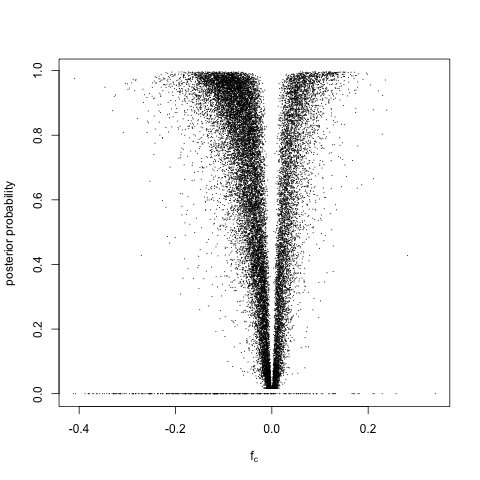

In [16]:
%%R 

# x1 is log2 frequencies for the 1st replicate of all timepts
# x2 is log2 frequencies for the 2nd replicate of all timepts
# ab1 is abundance thresholds for all 1st replicates
# ab2 is abundance thresholds for all 2nd replicates
# after this cell, these 4 are used again one more time considerably later--in the call to plot_fit that makes
# Log2 Frequency vs Time Plots for Constructs with Large Fitness File Output

rownames(x1)<-pA_pB 
rownames(x2)<-pA_pB

# TODO: ok, I don't know what this function does, but since ab1 and ab2 are calculated for replicates 1 and 2,
# I think that probably the "2 replicate" id is baked right into this function definition.
resf<-fit_ac_fc(x1,ab1,x2,ab2)
# I don't know what resf means ... maybe "resulting fit"?  Anyway, it is a list, which is unpacked below.

# TODO: 2-replicate assumption is baked into outputs of fit_ac_fc function
a1<-resf[[1]] # a1 is the initial condition (in log2 frequency) for each construct c for replicate 1
a2<-resf[[2]] # a2 is the initial condition (in log2 frequency) for each construct c for replicate 2
fc<-resf[[3]] # fc is the fitness of each construct c (calculated across both replicates)
sdfc<-resf[[4]] #standard error # Roman's comment says this is stderr, but I don't think it actually is--I think sdfc is the std deviation of the fitness of each construct c (calculated across both replicates)
p_t<-resf[[5]] #raw p-value from t-test # p_t is the raw p value of the fc of each construct c (calculated across both replicates)
lfdr_fc<-resf[[6]] #lfdr from p_t (Storey) # lfdr_fc is the local FDR of each construct (calculated across both replicates)
pp_fc<-1-lfdr_fc  # ab: I believe this is posterior probability of fc of each construct c (calculated across both replicates)
# Wikipedia: "the posterior probability of ... an uncertain proposition is the conditional probability that is assigned after the relevant evidence ... is taken into account".  Thus, higher equals more probable.
df<-resf[[7]] #degrees of freedom # df is the degrees of freedom of each construct c (calculated across both replicates)
allbad<-resf[[8]] #is TRUE when both experiments are bad (at most 1 good value) # allbad is a boolean value for each construct c that is true for all the constructs that lack at least 2 acceptable-abundance timepoints in BOTH experiments

# plot fc for all good constructs vs posterior probability of fc for all those same good constructs
plot(fc[!allbad],pp_fc[!allbad],pch=16,cex=0.2,xlab=expression(f["c"]),ylab="posterior probability")

## Plot of Histograms of Frequency by Construct Fitness

Light grey represents the full construct space, while dark grey represents only those constructs that pass the abundance thresholds chosen above.

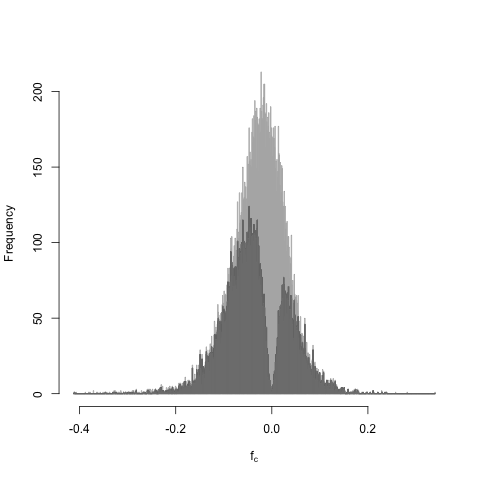

In [17]:
%%R 

# nn = number of *good* constructs
# r = nn random numbers pulled from a uniform distribution with (default) min of 0 and max of 1 
# set seed ONLY FOR TESTING
if (gUseSeed == TRUE) {
    set.seed(1)
}
r<-runif(nn) 
fr<-fc[r<pp_fc] # errr ... fc for all the constructs where the random ... posterior probability? ... is less than the actual calculated posterior probability for this construct?
# thus, fr is the distribution of fcs for constructs whose true pp of happening is greater than their random pp of happening--roughly, fcs of constructs whose fc values are more likely than chance
rge<-range(fc) # range of fcs across all constructs

# TODO: what determines the 0.001 for the break sequence?  Need to set in params?
plotOverlappingHist(fc[!allbad],fr,breaks=seq(rge[1]-.001,rge[2]+0.001,by=0.001),xlab=expression(f["c"]),ylab="Frequency")

## Histograms of Relative Abundance At Time Zero For Each Replicate

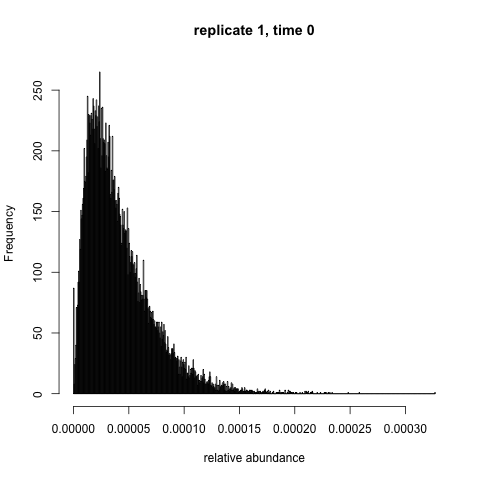

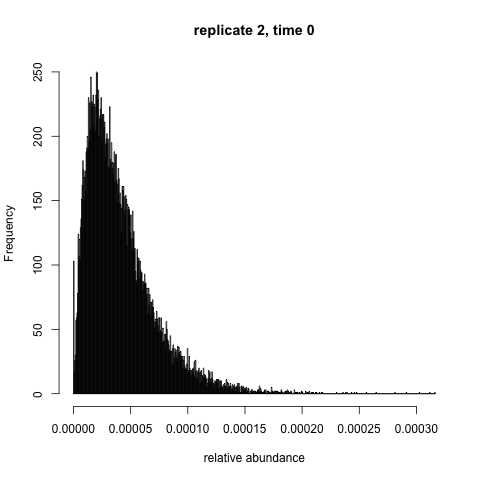

In [18]:
%%R 

# assign construct names to the newly-created ... arrays? ... of per construct info
names(fc)<-pA_pB
names(pp_fc)<-pA_pB
names(sdfc)<-pA_pB
# TODO: I suspect that the "2^"s here are reversing a log2 transform rather than
# hardcoding the # of replicates, so they are probably ok.  However, the repeat of the
# hist 2 times is clearly for the 2 replicates and needs to be refactored.
hist(2^a1,breaks=1000,xlab="relative abundance",main="replicate 1, time 0")
hist(2^a2,breaks=1000,xlab="relative abundance",main="replicate 2, time 0")

## Iterative Robust Least Squares Fitting

In [19]:
%%R

# nn = number of *good* constructs
# whatever u is, it is 0 for all bad and/or non-existent constructs and, at least at the beginning, one for all good constructs
u1<-rep(0,nn)
names(u1)<-pA_pB
u1[!allbad]<-1  #all other weights set to 1

# argh, heaven preserve me from variables fc0 and fc_0 that mean different things :(
fc0<-fc 

# just sets expected matrix size for all these--num probes by num probes, w/defaults of zero, and row/col names
fc_0<-matrix(0,nrow=nprobes,ncol=nprobes)
sdfc_0<-matrix(0,nrow=nprobes,ncol=nprobes)
w0_0<-matrix(0,nrow=nprobes,ncol=nprobes)
pp_0<-matrix(0,nrow=nprobes,ncol=nprobes)
rownames(fc_0)<-probes
colnames(fc_0)<-probes
rownames(sdfc_0)<-probes
colnames(sdfc_0)<-probes
rownames(w0_0)<-probes
colnames(w0_0)<-probes
rownames(pp_0)<-probes
colnames(pp_0)<-probes


# for 1 to number of genes - 1
for (i in 1:(n-1)) {
    # TODO: Ok, where did these "3"s come from?  From the expected number of probes per gene?
    # If so, that's *got* to be refactored out ...
   for (k in 1:3) {
       # index of current probe for current gene in probes array
      iprobe<-(i-1)*3+k
       # probes is entire probe name set in alphabetical order
      iprobe_name<-probes[iprobe]
       
       # note: for (i in 1:(n-1)) {
           #for (j in (i+1):n) {
       # nested loops here are the same as used above to generate ggnames...
       # for all possible second genes that come after the current first gene (i) 
      for (j in (i+1):n) {
          # for all the constructs of the second gene
         for (l in 1:3) {
            jprobe<-(j-1)*3+l
            jprobe_name<-probes[jprobe] # as for first gene, get index and then name of second gene
             
             #generate the construct name
            construct<-paste(iprobe_name,"_",jprobe_name,sep="")
            w0_0[iprobe_name,jprobe_name]<-u1[construct] #initial weights. non-existent pairs will have w0=0.  #ab: Roman's comment here says this is initial weights, but his comment in the irls function says that this is actually the "physical goodness" of each construct.  Seems to be integer booleans (i.e., 1 for true, 0 for false) 
            pp_0[iprobe_name,jprobe_name]<-pp_fc[construct] #initial weights. non-existent pairs will have w0=0 # ab: I don't think this comment is right either.  pp_fc are the posterior probabilities for the fc of each construct
            fc_0[iprobe_name,jprobe_name]<-fc0[construct]
            sdfc_0[iprobe_name,jprobe_name]<-sdfc[construct]
         }
      }
   }
}
w0_0<-w0_0+t(w0_0) #make symmetric
fc_0<-fc_0+t(fc_0)
pp_0<-pp_0+t(pp_0)

#robust fitting
# TODO: What is this 2 and do I need to worry about it?
res2<-irls(fc_0,w0_0,probes,ag=2,tol=1e-3,maxit=50)

fp<-res2[[1]] #these are probe fitnesses fp
#since fp is determined up to an additive constant, set the constant by 
#requiring that mean(fp[1:3]) = 0 (the null probes have zero fitness)
# ab: so, the three null probes are first in the fp array because their names are, or start with, zero, so
# they get put at the beginning by an alphabetical sort!
# TODO: got to refactor out this 3
mnull<-mean(fp[1:3])

fp<-fp-mnull
fc<-fc-mnull*2 # TODO: What is this 2 and do I need to worry about it?
# ah, I think I see where that 2 comes from: fp is at the probe level, but fc is at the *construct* level, and
# each *construct* has *two* probes in it; we're subtracting out the value we'd expect for a construct made out of
# *two* null probes.  So, no, I don't have to refactor out this two, because it is about the construct format 
# ("dual" crispr) not the number of replicates.

#now shift a's according to the relation ac<-mx-mt*fc # ab: um, this comment isn't adjacent to any code! And wasn't the freedom removed from the ac's back in the fit_ac_fc function?
#end removing freedom
#a, fc, and fp are fully set

rank_p<-rep(0,nprobes)
names(rank_p)<-probes
#find best probes
fp12<-fp
i<-1 #do null construct
# TODO: refactor 3s
rank_p[(i-1)*3+1:3]<-rank(abs(fp12[(i-1)*3+1:3])) #looking for the worst
# eee--for the above expression, i is fixed at one.  Thus, the above expression simplifies to:
# rank_p[(1-1)*3+1:3]<-rank(abs(fp12[(1-1)*3+1:3])) or
# rank_p[1:3]<-rank(abs(fp12[1:3]))

# TODO: refactor 3s (for # probes per gene)
# The 2 here *isn't* actually number of replicates; it is just that we did first "gene"--really the null--
# separately above.  The one difference between the equation used for the null and the one use for the 
# real genes is that for the null, abs is positive, whereas in the equation for the real genes, we are 
# examining the *negative* of the abs value.  This is because, for the null gene, we expect the real value 
# of fp for each of its probes to be zero--no effect on fitness.  Rank assigns ranks values in ascending order, so we 
# make them all positive using abs and say the one closest to zero is the best, the second closest to zero is
# the second best, and so forth.  For example, if abs(fp12[1:3]) is 0.290, 0.009, 1.48, then 
# rank(abs(fp12[1:3])) = 2, 1, 3 since the first value in abs(fp12[1:3]) has a rank of 2 (second-closest to zero),
# the econd value in abs(fp12[1:3]) has a rank of 1 (closest to zero), and so forth.
# However, for the real genes, we ... assume? ... that the probe with the fp 
# value *farthest* from zero is the best probe.  So we make all the fp values positive using abs, then make
# those abs values all negative.  Since rank assigns rank values in ascending order, the one with the most negative value
# (i.e., the largest absolute value of fp) will be ranked first, etc.
for (i in 2:n) { # for each gene, except the first one (which is really the null)
   rank_p[(i-1)*3+1:3]<-rank(-abs(fp12[(i-1)*3+1:3])) #looking for the best
}

#TODO: refactor 3, for number of probes per gene
p_rank<-3-rank_p # p_rank has the probes for each gene in reverse order from the way they are in rank_p; thus, the *best* probe in p_rank has the value 2 (3-1) whereas the worst has the value 0 (3-3), while in rank_p, the *best* probe has value 1 and the worst has value 3; it is used only to make the probe rank output file.

wpi1<-matrix(0,nrow=nprobes,ncol=nprobes)
# for each pair of probes
for (i in 1:nprobes) {
   for (j in 1:nprobes) {
       #TODO: refactor 3s
       #err ... subtracting 3 from rank_p will always either give a negative or zero.  But i guess it doesn't matter, as we're subtracting 3 from the rank of *both* probes and then multiplying, so the result will always be either positive or zero
      wpi1[i,j]<-(rank_p[i]-3)*(rank_p[j]-3) # product of reversed rank (i.e., best probe has biggest number) for the two probes in this probe pair
   }
}

f<-rep(0,n)
names(f)<-genes
for (i in 1:n) { # for each gene
    # TODO: refactor 3s
   w1<-(rank_p[(i-1)*3+1:3]-3)^2 #ansatz for weights # so, subtract 3 from the rank of each of the probes from this gene, then square (squaring since value will be neg or zero--see above?)
   f[i]<-sum(w1*fp[(i-1)*3+1:3])/sum(w1) #weighted mean # multiply fp for each probe for this gene by the anzatz weight for that probe, then sum across all the probes for this gene, and divide that sum by the sum of the anzatz weights for all probes for this gene

}
fmean<-f # fmean is array of zero values, one for each gene

pi1<-res2[[3]] #raw pi-scores per construct

mean_pi1<-matrix(0,nrow=n,ncol=n)
# oh, ffs, again with the for (i in 1:(n-1)) { ... for (j in (i+1):n) { construct
for (i in 1:(n-1)) { # for each first gene 
    # TODO: refactor 3s
   ixi<-3*(i-1)+1:3 # get range of probe indices for first gene 
   for (j in (i+1):n) { # for each second gene not already covered
      ixj<-3*(j-1)+1:3 # get range of probe indices for second gene 
       # reminder: w0_0 is the "physical goodness" of each construct.  Seems to be integer booleans (i.e., 1 for true, 0 for false)
      expressed1<-w0_0[ixi,ixj]>0 #define expressed probe pairs # ab: for this pair of genes
      
       # TODO: Not really sure what these two lines are doing; need to step through, understand 
       # sum(wpi1[ixi,ixj][expressed1]), understand what kind of matrix calculations are happening
      local_w1<-wpi1[ixi,ixj]/sum(wpi1[ixi,ixj][expressed1])*sum(expressed1)
       # wait, local_w1 doesn't seem to actually be *used* anywhere ...?
       
       # the denominator here is clearly just making sure we never get a divide-by-zero error ...
       # looks like we're getting mean of the weighted pi values across all expressed probes for this gene
      mean_pi1[i,j]<-sum((pi1[ixi,ixj]*wpi1[ixi,ixj])[expressed1])/max(small,sum(wpi1[ixi,ixj][expressed1]))
   }
}

uutri<-upper.tri(mean_pi1)
uutri[1,]<-FALSE #remove top line, 0 # why?
zi1<-mean_pi1[uutri]
zi<-zi1
npi<-length(zi1)

mmm<-length(fp) # number of probes
pi_iter<-matrix(0,nrow=npi,ncol=niter)
fp_iter<-matrix(0,nrow=mmm,ncol=niter)
f_iter<-matrix(0,nrow=n,ncol=niter)

utri<-upper.tri(fc_0)
ntri<-sum(utri)
ppi_iter<-matrix(0,nrow=ntri,ncol=niter)

for (iter in 1:niter) {
   cat("\n",iter,"\n")
   
   fc_1<-matrix(0,nrow=nprobes,ncol=nprobes) # same starting value as fc_0<-matrix(0,nrow=nprobes,ncol=nprobes)
    
   # set seed ONLY FOR TESTING
   if (gUseSeed == TRUE) {
       set.seed(iter)
   }
   fc0<-fc_0[utri]+rnorm(ntri,sd=sdfc_0[utri]) # ok, previous fc0 was fc0<-fc ; now we're adding a random normal to each fc, where each normal variable's mean is ?the sum of all fcs in the upper triangle?, and its stddev is the stddev of the fc of the analogous construct?
   pp0<-pp_0[utri] # gets the posterior probability of the fcs for constructs in the upper triangle
    
   # set seed ONLY FOR TESTING
   if (gUseSeed == TRUE) {
       set.seed(iter)
   }
   draw<-ifelse(runif(ntri)<pp0,1,0) # draw is 1 if the random posterior probability is less than the calculated posterior probability, zero otherwise
   fc_1[utri]<-fc0*draw # ok, multiplying by draw will set to zero every value in fc_1 where the posterior probability of the real fc was not more than you'd expect by chance
   fc_1<-fc_1+t(fc_1) # make fc_1 symmetric
   
    
    # TODO: repeat of code to run irls, retrieve outputs, constrain fp0
   #robust fitting
    # TODO: Do I need to worry about this 2?
   res2<-irls(fc_1,w0_0,probes,ag=2,tol=1e-3,maxit=50)

   fp0<-res2[[1]] #these are probe fitnesses fp

   #since fp is determined up to an additive constant, set the constant by 
   #requiring that mean(fp[1:3]) = 0 (the null probes have zero fitness
    # TODO: refactor 3
   mnull<-mean(fp0[1:3])
   fp0<-fp0-mnull
    # end repeat of code
   
    # TODO: near-repeat of code to set weighted mean f above; now have one f per iteration
   for (i in 1:n) {
       # TODO: refactor 3s
      w1<-(rank_p[(i-1)*3+1:3]-3)^2 #ansatz for weights
      f_iter[i,iter]<-sum(w1*fp0[(i-1)*3+1:3])/sum(w1) #weighted mean
   }
   # end near-repeat of code
    
   pi1<-res2[[3]] #raw pi-scores per construct # repeat code
   pi_scrambled<-pi1 # why put pi1 into pi_scrambled, then use it without changing it in any way? It *isn't* scrambled, it is just pi1
   
    # TODO: repeat of above code to set mean_pi1
   mean_pi1<-matrix(0,nrow=n,ncol=n)
   for (i in 1:(n-1)) {
        # TODO: refactor 3s
      ixi<-3*(i-1)+1:3
      for (j in (i+1):n) {
         ixj<-3*(j-1)+1:3
         expressed1<-w0_0[ixi,ixj]>0 #define expressed probe pairs
         local_w1<-wpi1[ixi,ixj]/sum(wpi1[ixi,ixj][expressed1])*sum(expressed1)
   
         mean_pi1[i,j]<-sum((pi_scrambled[ixi,ixj]*wpi1[ixi,ixj])[expressed1])/max(small,sum(wpi1[ixi,ixj][expressed1]))
      }
   }
   zi1<-mean_pi1[uutri]
    # end repeat of code
   
   pi_iter[,iter]<-zi1
   fp_iter[,iter]<-fp0
}

f_mean<-apply(f_iter,1,mean) # one fmean for each gene # wait, this value is never used!  What is output in the single-gene fitness file is f, not f_mean, although the stddev output there is f_sd (see right below)
f_sd<-apply(f_iter,1,sd) # output in single gene fitness file

fp_mean<-apply(fp_iter,1,mean) # never used
fp_sd<-apply(fp_iter,1,sd) # never used

pi_mean<-apply(pi_iter,1,mean) # used in several plots, output in pi score file
pi_sd<-apply(pi_iter,1,sd) # output in pi score file

pi_iter_null<-pi_iter-pi_mean #used directly below, then *redefined* (same way) and used (differently) in prepping for pi score output file

pi_null<-c(pi_iter_null,-pi_iter_null) # used directly below, and in histogram of pi scores
enull<-ecdf(pi_null) # used in plot of pi scores by fdr
emean<-ecdf(pi_mean) # used in plot of pi scores by fdr

1 0.3463658 0.02936167 
2 0.337134 0.01768298 
3 0.3329385 0.01306471 
4 0.3313054 0.01121013 
5 0.3310354 0.009486091 
6 0.3312456 0.007361561 
7 0.3312903 0.005592808 
8 0.3309372 0.00460974 
9 0.3302647 0.004164465 
10 0.3294298 0.003915499 
11 0.3285514 0.003687837 
12 0.3277005 0.003421093 
13 0.3269159 0.003108177 
14 0.3262167 0.002780619 
15 0.3256068 0.002466129 
16 0.3250811 0.002178373 
17 0.3246307 0.001922658 
18 0.3242458 0.001698425 
19 0.3239171 0.001502707 
20 0.323636 0.001328843 
21 0.3233957 0.00117316 
22 0.3231904 0.001033189 
23 0.3230151 0.0009070964 

 1 
1 0.2691163 0.08795553 
2 0.1930625 0.04756417 
3 0.1523217 0.02563641 
4 0.1323536 0.01357003 
5 0.1232291 0.006909436 
6 0.1191607 0.003431341 
7 0.1173196 0.001694647 
8 0.1164603 0.0008417878 

 2 
1 0.2626336 0.08914425 
2 0.1852919 0.04756977 
3 0.1441076 0.02517187 
4 0.1245033 0.01213894 
5 0.1160779 0.005554647 
6 0.1124972 0.002532582 
7 0.1109158 0.001193575 
8 0.1101774 0.0006034353 


## Histogram of Pi Scores

Smooth curve represents expected distribution given null hypothesis.

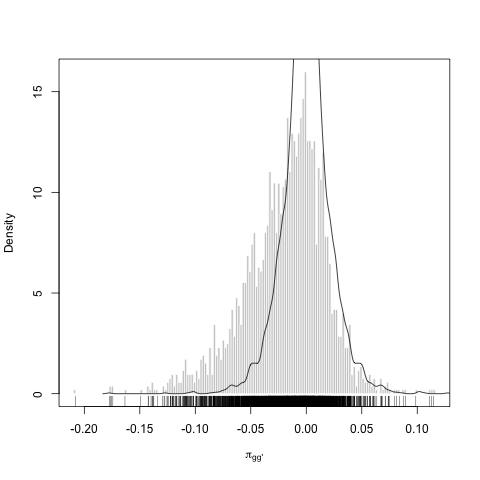

In [20]:
%%R 

rge<-range(pi_mean)
# TODO: where does 0.002 in break seq come from?  Should we set in params?
h<-hist(pi_mean,breaks=seq(rge[1]-0.002,rge[2]+0.002,by=0.002),main="",xlab=expression(pi["gg'"]),col="grey80",border=FALSE,probability=TRUE)
   d<-density(pi_null,bw=0.002)
   lines(d,col="black")
   rug(pi_mean)
box()

## Plot of Pi Score by FDR for Left and Right Tails

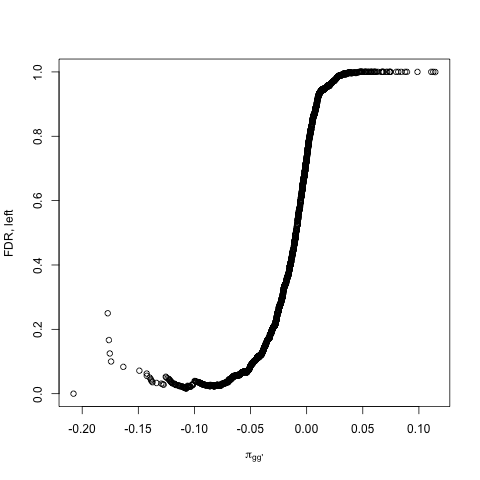

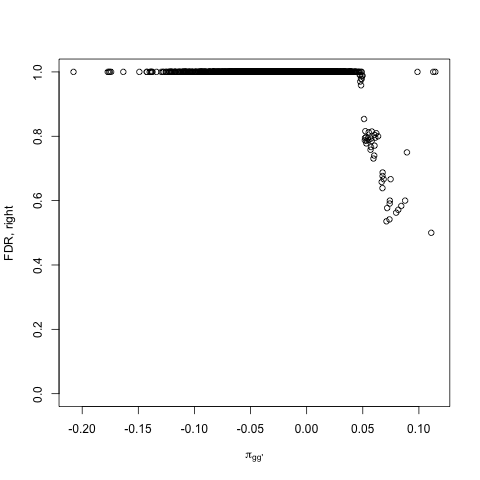

In [21]:
%%R 

fdr_left<-pmin(1,enull(pi_mean)/emean(pi_mean))
fdr_right<-pmin(1,(enull(-pi_mean))/(1-emean(pi_mean)))
plot(pi_mean,fdr_left,ylim=c(0,1),xlab=expression(pi["gg'"]),ylab="FDR, left") #left tail test
plot(pi_mean,fdr_right,ylim=c(0,1),xlab=expression(pi["gg'"]),ylab="FDR, right") #right tail test

## Pi Score File Output

In [24]:
%%R 

z<-pi_mean/sd(pi_mean)

pi_iter_null<-pi_iter-pi_mean
abspi<-abs(pi_mean)
PP<-apply(abs(pi_iter_null)<abspi,1,mean)

oPP<-order(z)

#get names of these gene pairs
# These g1//g2, etc hardcodes are ok because represent DUAL crispr genes
names_of_g1<-g1names[uutri]
fg1<-f[names_of_g1]
names_of_g2<-g2names[uutri]
fg2<-f[names_of_g2]
fg12<-fg1+fg2
names_of_gg<-ggnames[uutri]

res<-data.frame(names_of_gg,names_of_g1,fg1,names_of_g2,fg2,fg12,pi_mean,pi_sd,PP,abspi,fdr_left,fdr_right,z)
# TODO: Let's refactor these colnames, file suffix, and separator somewhere easier to manage
colnames(res)<-c("gene_gene","geneA","fA","geneB","fB","fA+fB","pi","sd","PP","abs pi","FDR left","FDR right","z")
#TODO: remove format call here; added to aid in testing
write.table(format(res[oPP,], digits=14),file=file.path(gScoringDir, paste(project,"_pi.txt",sep="")),
            sep="\t",row.names=FALSE,quote=FALSE)
#write.table(res[oPP,],file=paste(project,"_pi.txt",sep=""),sep="\t",row.names=FALSE,quote=FALSE)

## Log2 Frequency vs Time Plots for Constructs with Large Fitness File Output

The plots are written to a PDF file.  Only constructs with an absolute fitness greater than or equal to the below minfc value are included.

In [25]:
%%R 

pdf(file.path(gScoringDir, paste(project,".pdf",sep="")))
par(pty="s",mfrow=c(1,1))
# TODO: I don't know what this is doing, but it looks like the method interface has 2 replicates baked right in ...
plot_fit(x1,a1,fc,ab1,x2,a2,fc,ab2,minfc=0.10)
dev.off()

quartz_off_screen 
                2 


## Construct Fitness File Output

In [26]:
%%R 

resp<-data.frame(pA_pB,fc,sdfc)
# TODO: refactor file suffix, separator into easier to manage location
write.table(resp,file=file.path(gScoringDir, paste(project,"_fc.txt",sep="")),sep="\t",row.names=FALSE,quote=FALSE)

## Number of Constructs Below Abundance Threshold in Both Replicates

In [27]:
%R print(sum(bad1 & bad2))

[1] 287


## Histogram of Construct Fitnesses

Smooth curve represents fitted density function on data shown as bars.

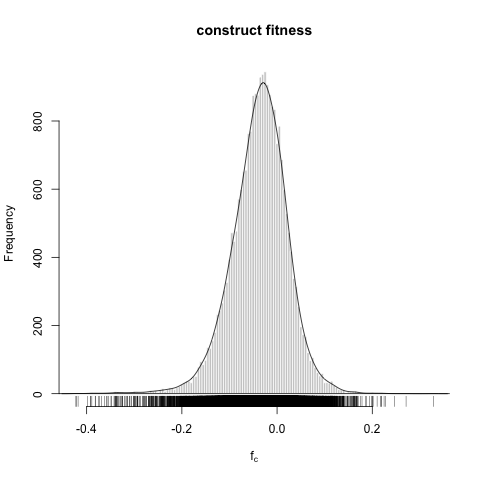

In [28]:
%%R 

# TODO: are these bads for the 2 genes or the 2 replicates?  Former ok, latter not
good<-!bad1 & !bad2

rge<-range(fc)
# TODO: where do the 0.005s in the break seq come from?  Do they need to be set in params?
hh<-hist(fc[!allbad],breaks=seq(rge[1]-0.005,rge[2]+0.005,by=0.005),main="construct fitness",col="grey80",border=FALSE,xlab=expression(f["c"]))
d<-density(fc[!allbad],bw=0.01)
lines(d$x,d$y*sum(hh$counts)*0.005,col="black")

rug(fc[!allbad])
abline(h=0)

## Plots of Experimental and Fitted Frequencies

Scatterplots are provided both showing comparisons of frequencies (either fitted or experimental) between any two timepoints of the same replicate.  Additionally, MA plots for each pair of timepoints for each replicate are provided for both fitted and experimental frequencies.

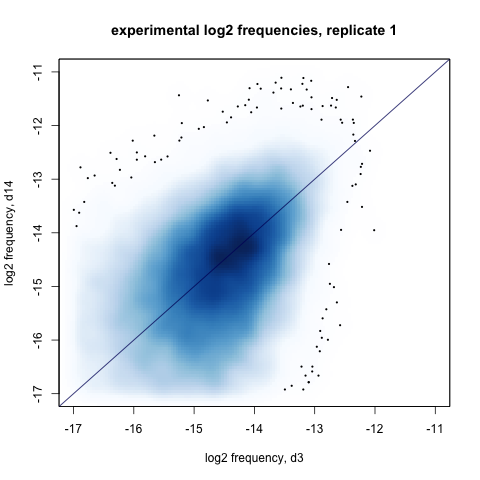

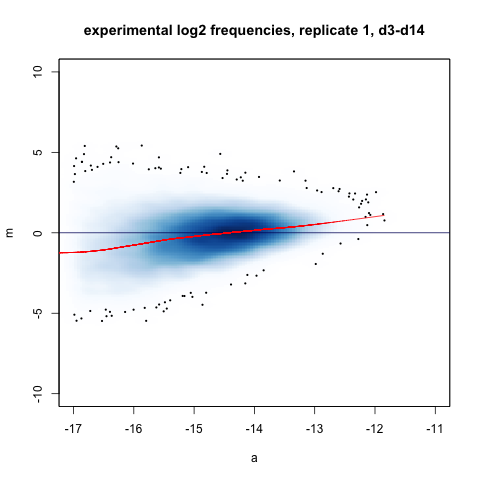

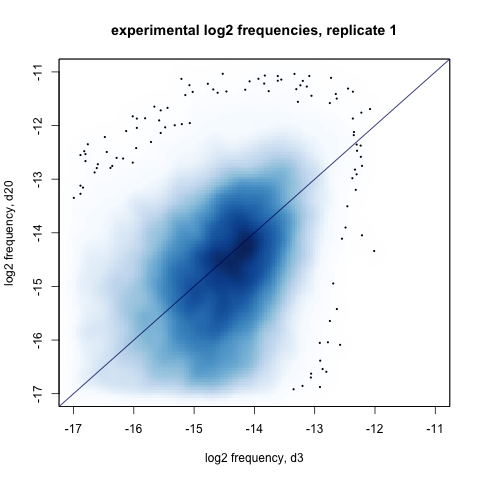

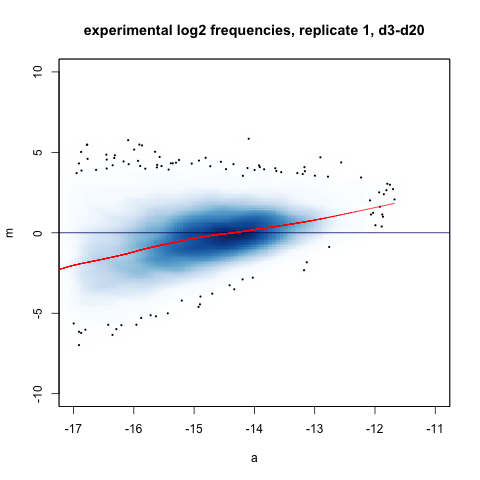

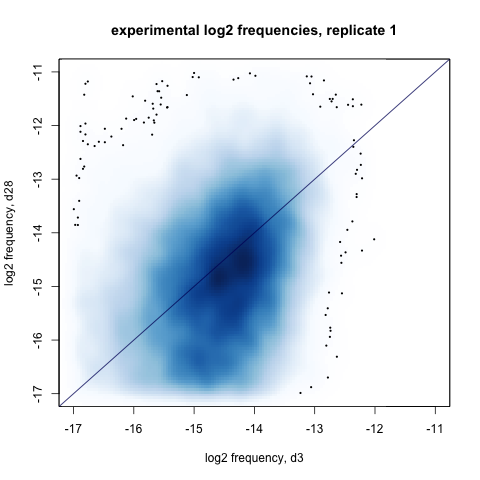

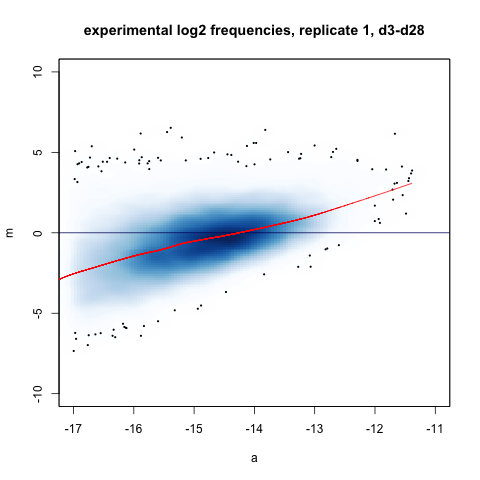

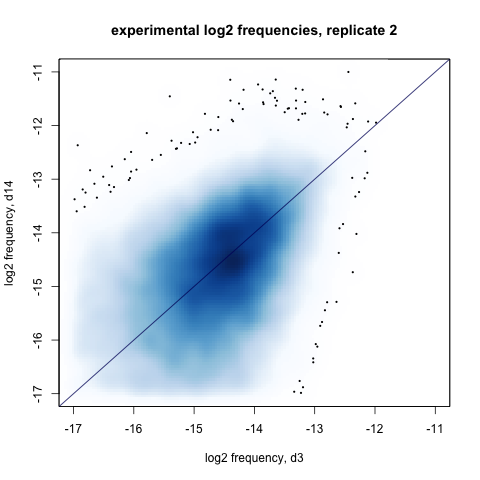

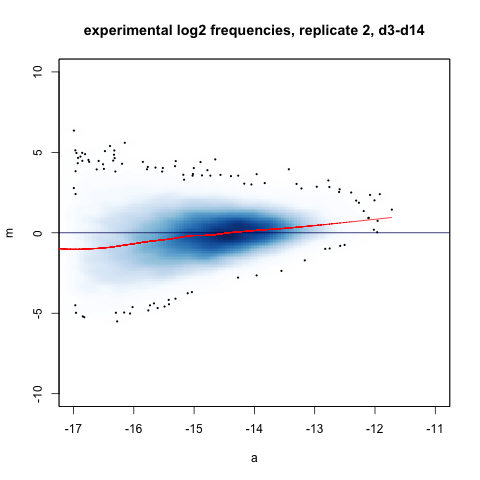

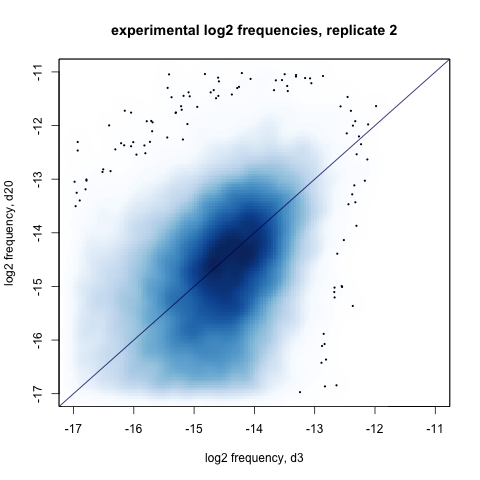

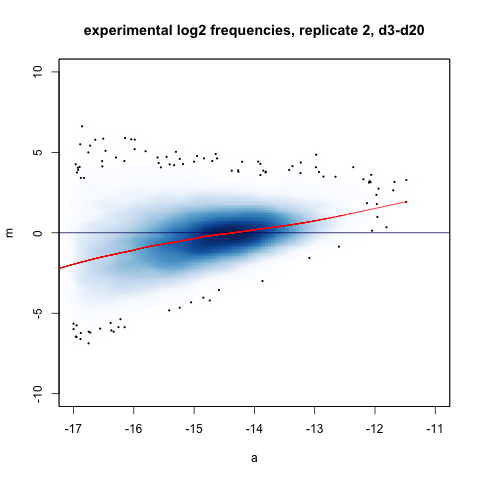

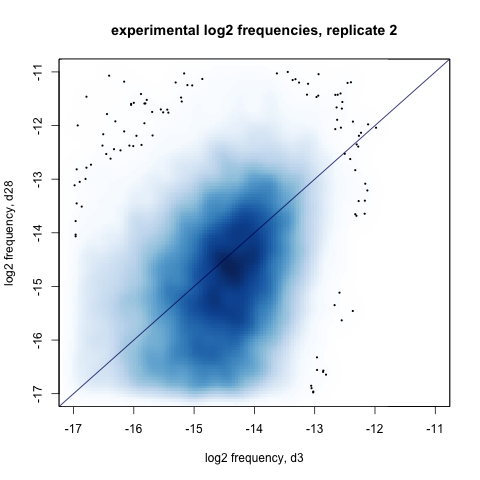

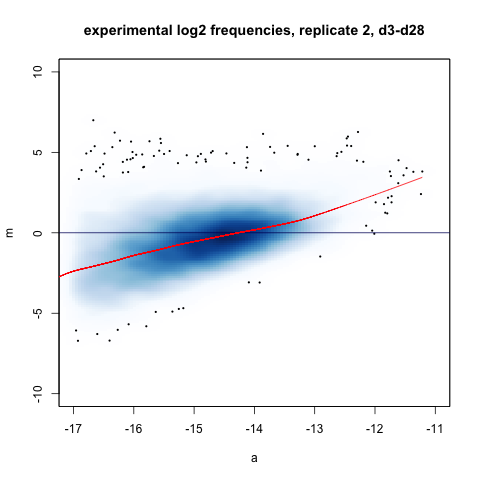

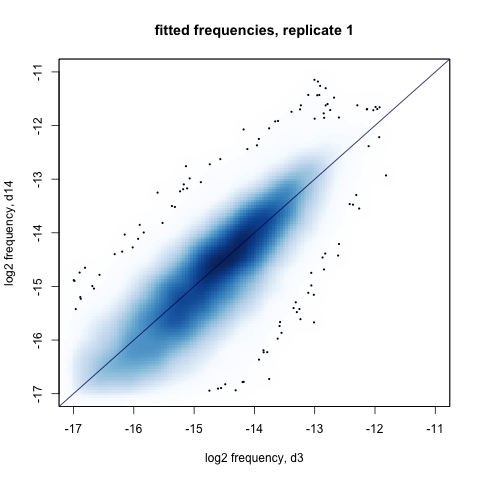

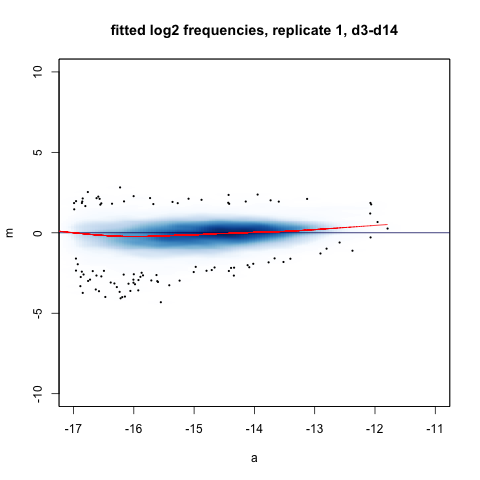

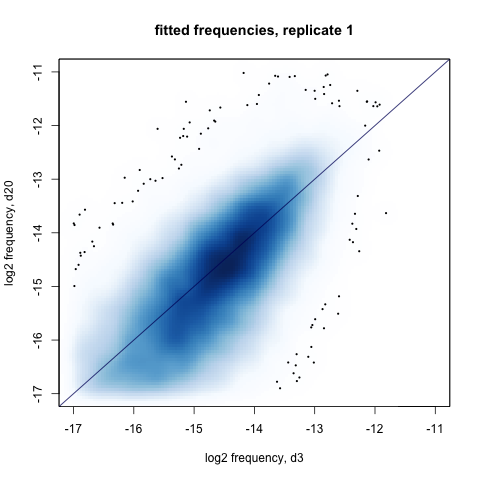

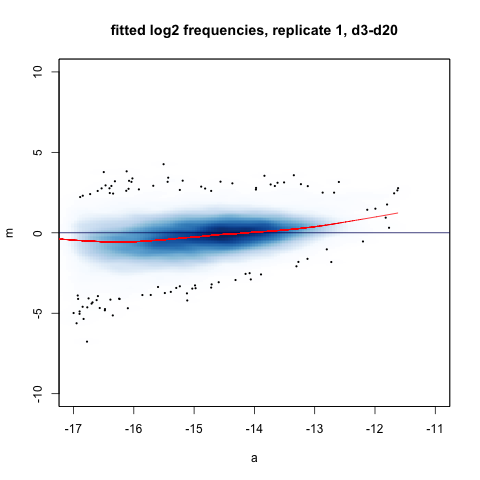

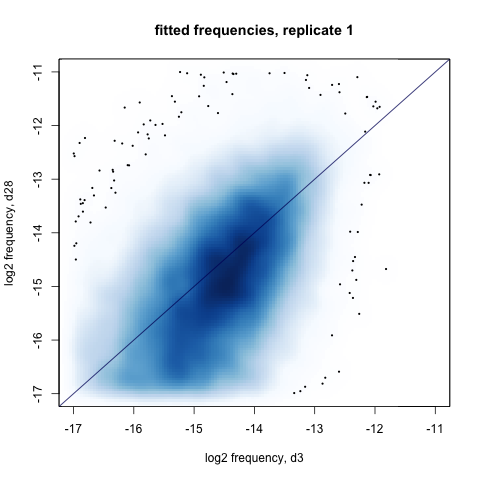

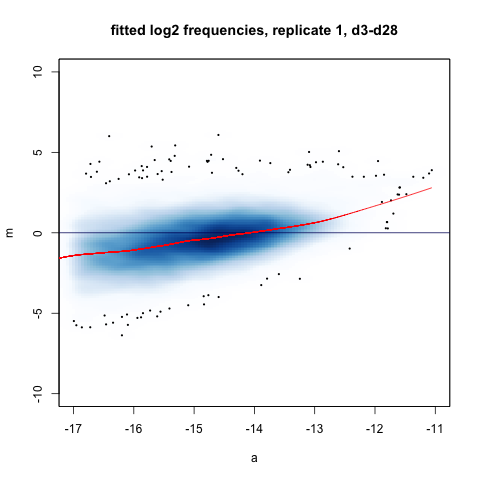

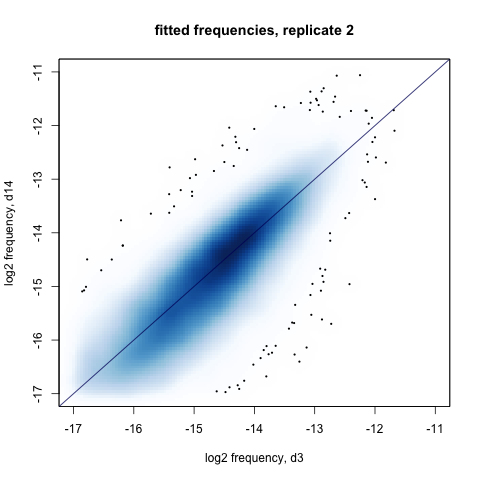

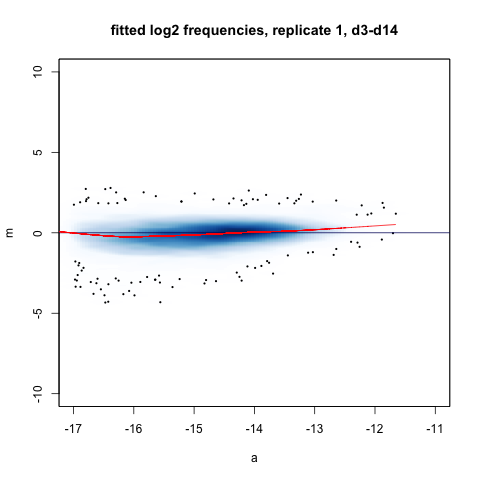

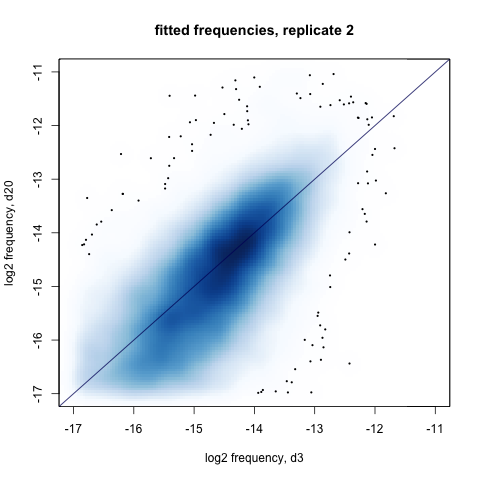

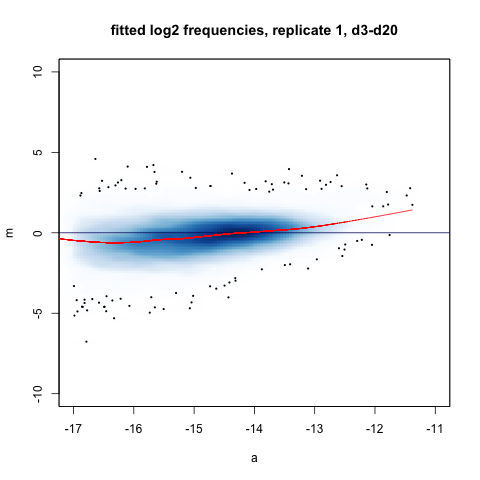

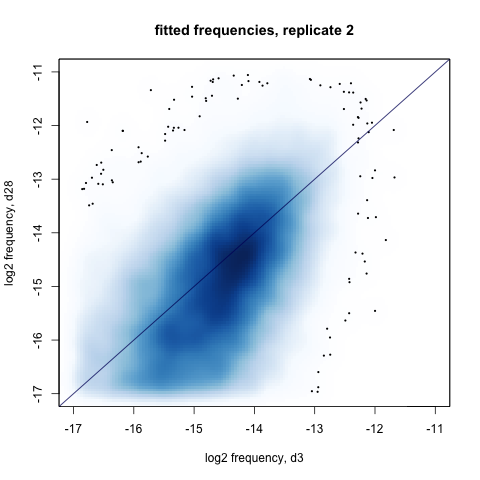

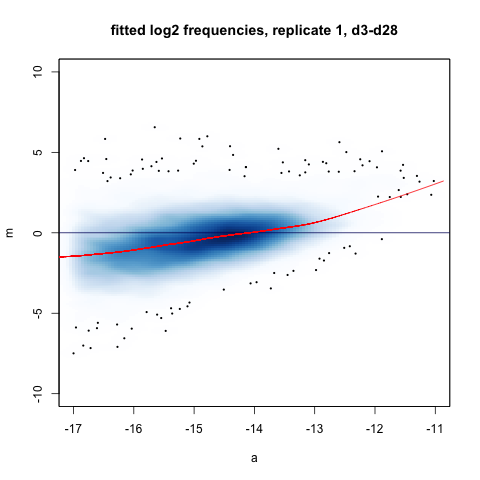

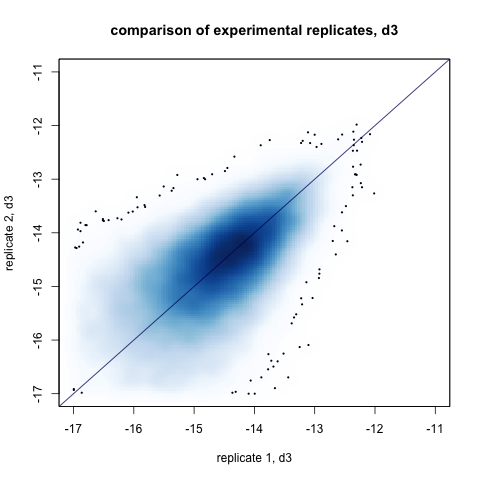

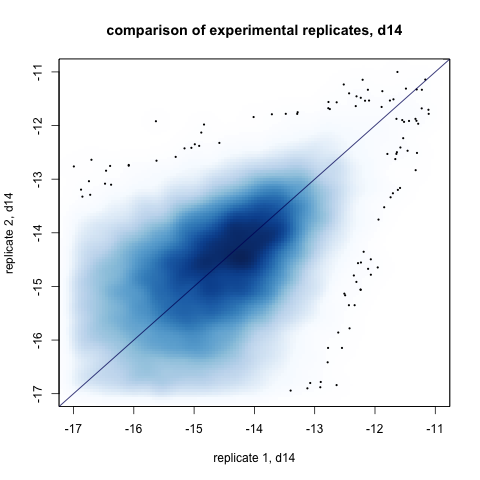

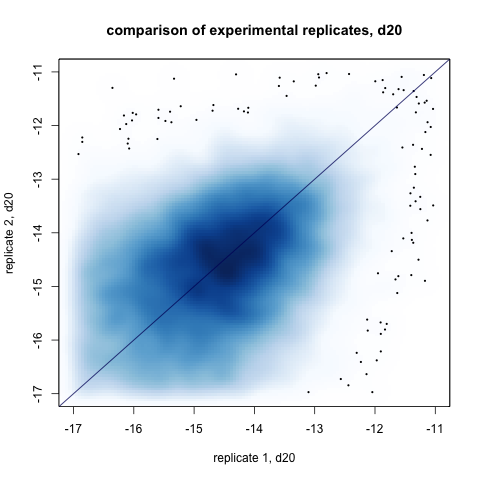

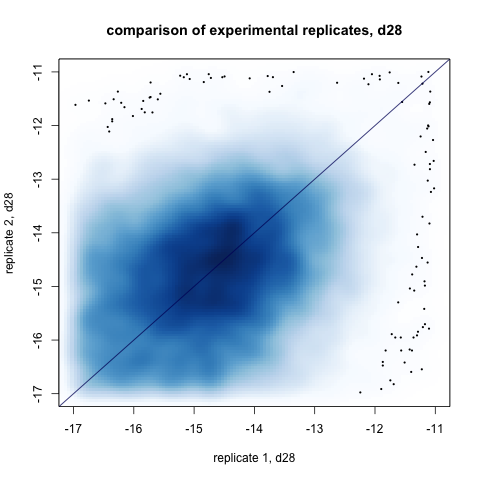

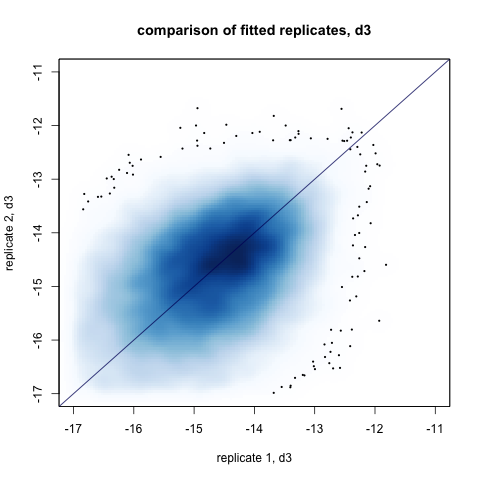

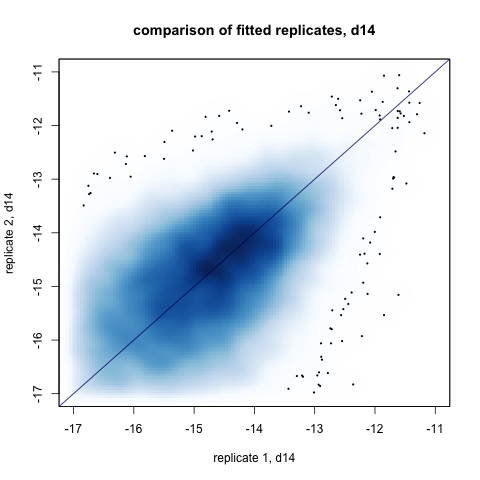

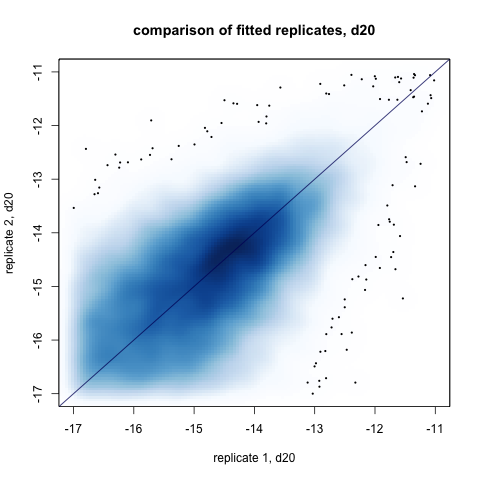

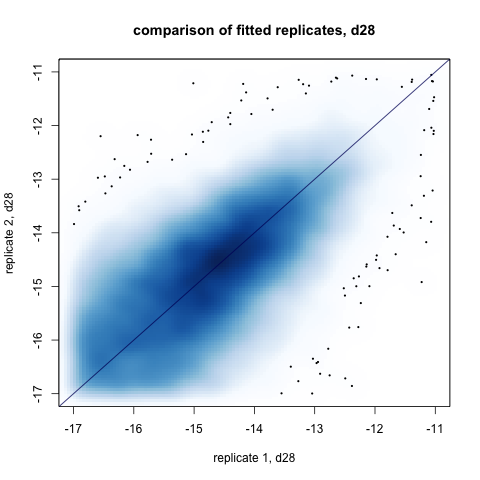

In [29]:
%%R 

plot_scatterplots()

## Probe Rank File Output

In [30]:
%%R 

resp<-data.frame(probes,p_rank)
# TODO: refactor file suffix, separator into easier to manage location
write.table(resp,file=paste(project,"_p.txt",sep=""),sep="\t",row.names=FALSE,quote=FALSE)

## Single-Gene Fitness File Output

Output includes both fitness and fitness standard deviation for each gene.

In [31]:
%%R 

resy<-data.frame(genes,f,f_sd)
# TODO: refactor col names, file suffix, separator into easier to manage location
colnames(resy)<-c("gene","f","sd")
write.table(resy[-1,],file=file.path(gScoringDir, paste(project,"_f.txt",sep="")),sep="\t",row.names=FALSE,quote=FALSE)

## Single Gene Fitness Plot

Note that since both axes contain the same data, this is equivalent to a rug plot shifted by 45 degrees.

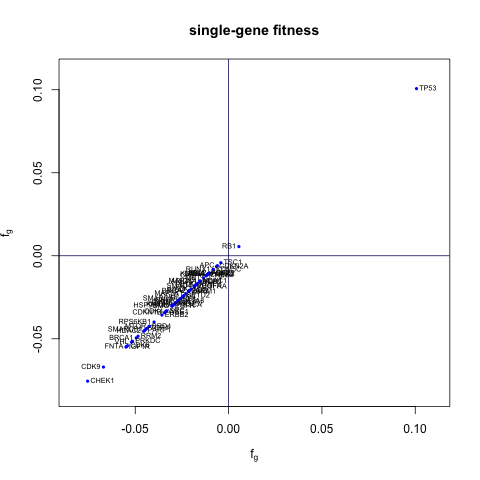

In [32]:
%%R 

# TODO: since this is always on diagonal, should we refactor to be rug plot?

rge<-range(f)*1.1 #with some margin
plot(f[-1],f[-1],pch=16,cex=0.6,col="blue",xlim=rge,ylim=rge,xlab=expression(f["g"]),ylab=expression(f["g"]),main="single-gene fitness")
abline(v=0,h=0,col="#000066")
# TODO: Do I need to worry about these 2s?
text(f[-1],f[-1],cex=0.6,labels=genes[-1],pos=((rank(f[-1]) %% 2)+1)*2,offset=0.2)